In [1]:
import torch
import numpy as np
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import re
from datetime import datetime
import warnings
import spacy
import optuna
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, RobertaForSequenceClassification, RobertaTokenizer, AutoConfig, RobertaTokenizer, RobertaModel, EarlyStoppingCallback
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import re
import spacy
from transformers import RobertaTokenizer, RobertaModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.sparse import hstack
from sklearn.decomposition import LatentDirichletAllocation
from imblearn.over_sampling import SMOTE

In [2]:
# убираем команды предупреждений
warnings.filterwarnings('ignore')

In [3]:
# https://www.kaggle.com/datasets/sujaykapadnis/bitcoin-tweets

In [4]:
TRAIN_DIRECTORY = "big-files/tweets.csv"

In [5]:
# Установите свои ключи API
API_KEY = ''
API_KEY_SECRET = ''
ACCESS_TOKEN = ''
ACCESS_TOKEN_SECRET = ''
BEARER_TOKEN = ""

# 1. Data Exploration and Preprocessing

### 1.1 Loading the Dataset and Understanding its Structure

In [6]:
# Load the data
df = pd.read_csv(TRAIN_DIRECTORY)
df

,token,date,reply_count,like_count,retweet_count,quote_count,text,sentiment_label,sentiment_score
0,bitcoin,2022-01-01 00:00:00.000,20,207,31,3,Most people underestimate the impact #Bitcoin ...,Neutral,0.717482
1,bitcoin,2022-01-01 00:00:00.000,232,3405,286,27,#Bitcoin has started a new yearly candle https...,Neutral,0.810814
2,bitcoin,2022-01-01 00:00:00.000,2,861,12,0,@DESTROYBINARY did people forget that the amog...,Neutral,0.606978
3,bitcoin,2022-01-01 00:00:00.000,18,306,30,9,"In 2017, miners attempted to assert control ov...",Negative,0.510956
4,bitcoin,2022-01-01 00:00:00.000,35,721,35,1,Yearly Close \nMonthly Close\nDaily Close\n\nh...,Positive,0.988296
...,...,...,...,...,...,...,...,...,...
76792,bitcoin,2023-06-22 00:00:00.000,8,204,35,2,IMF says while a few countries have banned #Bi...,Negative,0.615765
76793,bitcoin,2023-06-22 00:00:00.000,8,298,17,4,"Fear, Greed &amp; Bitcoin | #SheCrypto https:/...",Neutral,0.687251
76794,bitcoin,2023-06-22 00:00:00.000,17,86,17,0,I know I may be unpopular for saying this but ...,Neutral,0.532809
76795,bitcoin,2023-06-22 00:00:00.000,193,3048,771,42,#Bitcoin now has the support of presidential c...,Positive,0.935171


In [7]:
# We see information about the dimension of our dataframe
df.shape 

(76797, 9)

In [8]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76797 entries, 0 to 76796
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   token            76797 non-null  object 
 1   date             76797 non-null  object 
 2   reply_count      76797 non-null  int64  
 3   like_count       76797 non-null  int64  
 4   retweet_count    76797 non-null  int64  
 5   quote_count      76797 non-null  int64  
 6   text             76797 non-null  object 
 7   sentiment_label  76797 non-null  object 
 8   sentiment_score  76797 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 5.3+ MB


In [9]:
# The number of unique values for each column
df.nunique() 

token                  1
date                 538
reply_count         1821
like_count          7323
retweet_count       2690
quote_count          584
text               75955
sentiment_label        3
sentiment_score    75530
dtype: int64

The data is well-structured and complete, with no missing values. This ensures that it’s ready for analysis without needing extensive preprocessing, allowing for accurate insights into user behavior and sentiment around Bitcoin.

### 1.2. Perform basic exploratory data analysis (EDA) to understand the distribution

In [10]:
# Check for missing values
df.isnull().sum()

token              0
date               0
reply_count        0
like_count         0
retweet_count      0
quote_count        0
text               0
sentiment_label    0
sentiment_score    0
dtype: int64

In [11]:
# Check for duplicates and non-dublicates
df.duplicated().value_counts()

False    76734
True        63
Name: count, dtype: int64

In [12]:
# Remove duplicates
df = df.drop_duplicates()

In [13]:
# Sentiment describe
df["sentiment_score"].describe()

count    76734.000000
mean         0.713478
std          0.141160
min          0.340653
25%          0.592395
50%          0.710428
75%          0.833892
max          0.993558
Name: sentiment_score, dtype: float64

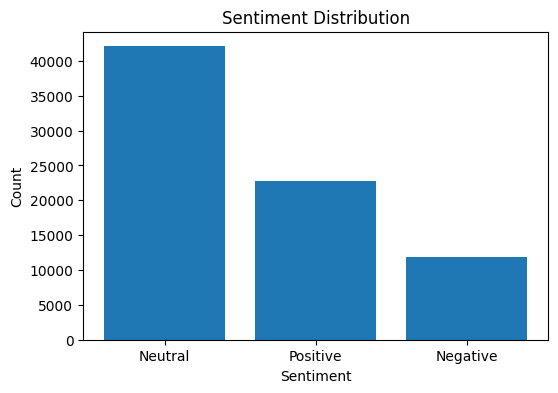

In [14]:
# Visualization of sentiments
sentiment_counts = df['sentiment_label'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

As we can see, we have the most neutral tweets. This may have a slightly bad effect on determining positive and negative moods, since our program will recognize them better than others, Especially negative ones, since we have the least of them.

In [15]:
# # Загрузка модели английского языка
nlp = spacy.load("en_core_web_sm")
# # python -m spacy download en_core_web_sm

In [16]:
def clean_text(text):
    # Очистка текста твита
    # text = re.sub(r"^RT\s+", "", text)  # Удаление 'RT' (повторных твитов) в начале текста
    # text = re.sub(r"http\S+", "", text)  # Удаление URL
    # text = re.sub(r"@\w+", "", text)  # Удаление упоминаний (например, @username)
    # text = re.sub(r'#', '', text)  # Удаление символа '#' только (например, #hashtag)
    # text = re.sub(r"[^\x00-\x7F]+", "", text)  # Удаление не-ASCII символов
    # text = re.sub(r"[^A-Za-z0-9\s.]+", "", text)  # Удаление специальных символов, кроме точек
    # text = re.sub(r"\.{2,}", " ", text)  # Замена нескольких точек на один пробел
    # text = re.sub(r"\s+", " ", text)  # Замена нескольких пробелов на один пробел
    # text = text.strip()  # Удаление пробелов в начале и конце строки
    # text = text.lower()  # Приведение текста к нижнему регистру

    # # Возвращаем очищенный текст
    # return text


    # Очистка текста твита
    
    text = re.sub(r"^RT\s+", "", text)  # Remove 'RT' (re-tweets) at the beginning of the text
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions (e.g., @username)
    text = re.sub(r'#', '', text)  # Remove the '#' symbol only (e.g., #hashtag)
    text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove non-ASCII characters
    text = re.sub(r"[^A-Za-z0-9\s.]+", "", text)  # Remove special characters except periods
    text = re.sub(r"\.{2,}", " ", text)  # Replace multiple periods with a single space
    text = re.sub(r"\s+", " ", text)  # Replace multiple spaces with a single space
    text = text.strip()  # Remove spaces from the beginning and end of the string
    text = text.lower()  # Convert the text to lowercase

    # Лемматизация текста
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if token.lemma_ not in ('-', '', ' ') and len(token.lemma_) > 1]  # Исключаем пустые леммы, знаки препинания и одиночные буквы
    
    # # Возвращаем текст с леммами, объединенными в одну строку
    return " ".join(lemmas)

In [17]:
# Get cleaned text
df["clean_text"] = df["text"].apply(clean_text)

In [18]:
# Join all in one for using
all_text = ' '.join(df["clean_text"])

In [19]:
# Creating the word cloud while excluding stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)

In [20]:
# Extract frequencies from the word cloud
word_frequencies = wordcloud.process_text(all_text) 
word_freq_counter = Counter(word_frequencies)   # sort and display word frequencies

for word, freq in word_freq_counter.most_common(30): # Display 10 words
    print(f"{word}: {freq}")

bitcoin: 34203
btc: 5713
will: 5450
go: 3974
now: 3540
crypto: 3413
new: 3069
amp: 2928
buy: 2911
people: 2803
make: 2722
time: 2649
see: 2575
one: 2556
break: 2518
say: 2338
use: 2270
today: 2189
world: 2174
money: 2133
buy bitcoin: 1900
think: 1893
need: 1883
day: 1869
bitcoin bitcoin: 1849
year: 1835
want: 1783
still: 1747
come: 1732
well: 1729


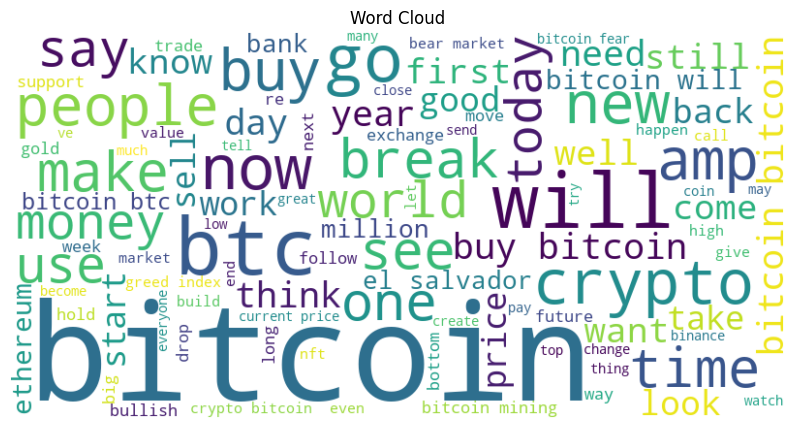

In [21]:
# Displaying the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud")
plt.show()

Conclusion:

"Bitcoin" and "BTC": The overwhelming frequency of "bitcoin" and "btc" emphasizes that Bitcoin is the central topic of conversation. The repetition of "bitcoin bitcoin" suggests intense focus or emphasis on the cryptocurrency.
"Crypto": The term "crypto" being frequent alongside Bitcoin indicates discussions often encompass the broader cryptocurrency market, though Bitcoin remains the primary subject.

"Will" and "Going": These words highlight that future predictions, plans, or expectations are major themes. People are likely discussing what will happen with Bitcoin, where the market is going, and what actions to take.

"New," "Now," "Today," "Year": These terms suggest that tweets are often focused on current events, recent developments, or upcoming trends within the crypto space. There's a clear emphasis on what’s happening at the moment and how it relates to the immediate future.

"Buy," "Money," "Time": The frequent mention of "buy" and "money" suggests discussions about investing in Bitcoin, the value of money, and the timing of these investments. It implies a financial motive or interest in the economics of Bitcoin.
"First": This word could relate to milestones, achievements, or important events in the Bitcoin or cryptocurrency world, such as first-time investments, first adopters, or key events.

"People," "World," "See," "Day": These words indicate a broader discussion that involves not just technical or financial aspects but also social and global implications. Conversations may involve how Bitcoin is perceived worldwide, its impact on people's lives, and how it integrates into daily life.
Overall, these words suggest that your tweets are deeply engaged with both the current state and future possibilities of Bitcoin and the broader cryptocurrency market, with a mix of financial analysis, social implications, and global perspectives.

In [22]:
# Converting a date to a normal format
df["date"] = pd.to_datetime(df["date"], errors="coerce")
# Lets make sure that the conversion was successful
df["date"].head(3)

0   2022-01-01
1   2022-01-01
2   2022-01-01
Name: date, dtype: datetime64[ns]

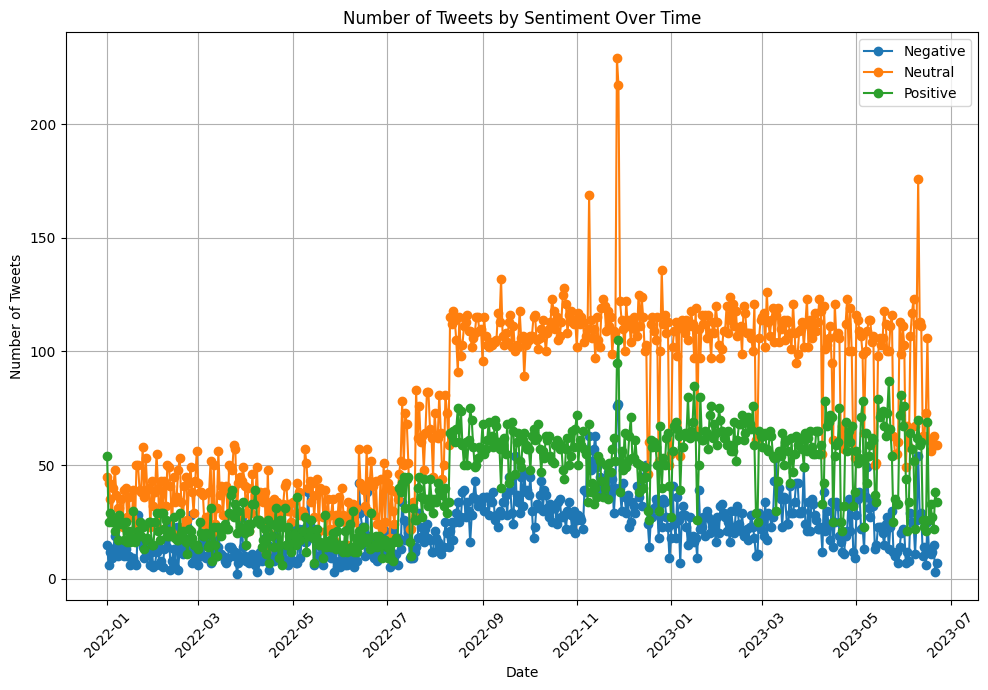

In [23]:
# Aggregating data by date and sentiment
sentiment_counts = df.groupby(["date", "sentiment_label"]).size().unstack().fillna(0).reset_index()

# Visualization
plt.figure(figsize=(10, 7))

# Plotting the number of tweets with different sentiments
for sentiment in sentiment_counts.columns[1:]:
    plt.plot(sentiment_counts["date"], sentiment_counts[sentiment], marker="o", linestyle="-", label=sentiment)

# Configuring the plot
plt.title("Number of Tweets by Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


Conclusion: 
- The data on tweet counts shows that activity varies daily. 
- Periods with a high number of tweets do not always coincide with periods when the average sentiment was higher or lower. This suggests that tweet activity does not always directly affect the overall sentiment on social media. - A sharp increase or decrease in tweet counts may correspond with specific events that influence the overall sentiment.

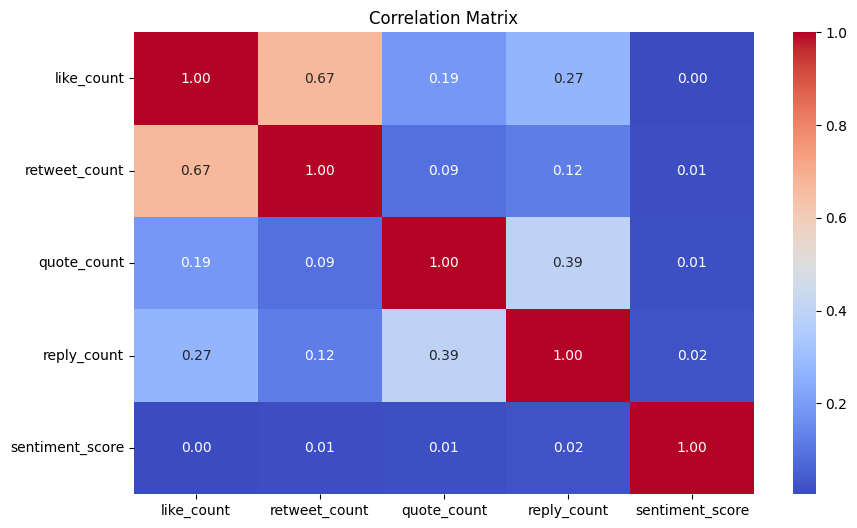

In [24]:
# Correlation matrix
correlation_matrix = df[["like_count", "retweet_count", "quote_count", "reply_count", "sentiment_score"]].corr()
# Building a heat map
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Conclusion:
- There is a moderate correlation between likes and retweets, indicating that tweets with more likes tend to also have more retweets. However, there is little to no relationship between these metrics and the tweet’s sentiment or the number of times the tweet is quoted.
- Retweets and quotes have a very weak relationship with each other.
- Sentiment is almost independent of likes, retweets, and quotes.

These results suggest that tweet engagement metrics (likes, retweets, and quotes) are generally not strongly related to each other or to the sentiment of the tweets.
Sentiment_score can be considered as an independent variable that is unlikely to be effectively predicted based on interaction data alone

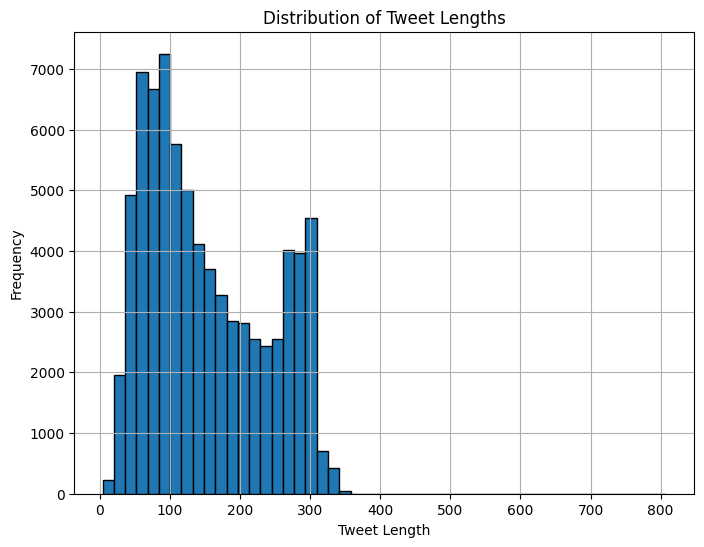

In [25]:
# Tweet length
plt.figure(figsize=(8, 6))
plt.hist(df['text'].apply(len), bins=50, edgecolor='black')
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

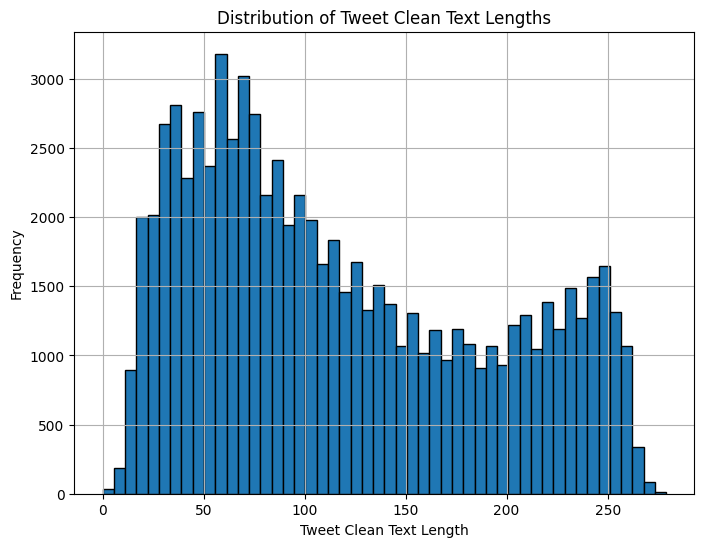

In [26]:
# Tweet length clean text
plt.figure(figsize=(8, 6))
plt.hist(df['clean_text'].apply(len), bins=50, edgecolor='black')
plt.title("Distribution of Tweet Clean Text Lengths")
plt.xlabel("Tweet Clean Text Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Conclusion:
The length of the cleaned tweets still varies greatly, which indicates that the cleaning has not significantly changed the distribution of tweet lengths, although it is worth recognizing that the number of abnormal tweets has significantly decreased, which will greatly facilitate our work.

# 2. Data Preprocessing and Tokenization

### 2.1 Tokenize the text data using a pre-trained tokenizer from a transformer model

In [27]:
# Load the tokenizer for the twitter-roberta-base-sentiment-latest model
tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", truncation=True, do_lower_case=True)

In [28]:
model = RobertaModel.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", 
                                                          num_labels=3,  # Number of output labels
                                                          ignore_mismatched_sizes=True,  # Ignore size mismatches if they occur
    )

In [29]:
# Функция для получения эмбеддингов текста
# Получение эмбеддингов для всех твитов/ разделение
def get_embeddings(texts, max_length=128, batch_size=512):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
        with torch.no_grad():
            outputs = model(**tokens)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)



In [30]:
# Получение эмбеддингов для всех твитов
embeddings = get_embeddings(df['clean_text'].tolist())
embeddings

array([[ 6.8269002e-01, -7.4251461e-01, -5.0844693e-01, ...,
        -1.6898766e+00, -3.4316441e-01, -2.2483779e-02],
       [ 2.2136302e-01, -2.0777605e-01, -2.5547719e-01, ...,
        -1.5502467e+00, -3.9637054e-04,  8.8934489e-02],
       [ 4.7483599e-01, -7.9238009e-01, -1.8317848e-01, ...,
        -1.6888827e+00, -4.6770391e-01,  9.4831216e-01],
       ...,
       [ 2.3067701e-01, -1.0730298e-01,  2.5132126e-01, ...,
        -3.1336924e-01, -5.1851493e-01,  3.2990548e-01],
       [ 2.0150210e-01, -2.7377367e-01, -2.7908614e-01, ...,
        -1.3459949e+00,  4.0545827e-01, -2.1409223e-02],
       [ 2.1509092e-01, -4.1032666e-01, -2.0941291e-03, ...,
        -1.5622008e+00, -1.9916934e-01,  2.3517631e-01]], dtype=float32)

In [31]:
# from sentence_transformers import SentenceTransformer
# import pandas as pd
# import numpy as np

# # Загрузка предобученной модели
# model = SentenceTransformer('all-MiniLM-L6-v2')

# # Преобразование твитов в эмбеддинги
# embeddings = model.encode(df['clean_text'].tolist(), show_progress_bar=True)

# # Преобразование эмбеддингов в DataFrame для удобства работы
# embeddings_df = pd.DataFrame(embeddings)

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Преобразование текста в TF-IDF векторы
vectorizer = TfidfVectorizer(stop_words='english')
ngram_features  = vectorizer.fit_transform(df['clean_text'])

In [118]:
from sklearn.preprocessing import StandardScaler
# Масштабирование эмбеддингов
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

In [119]:
from sklearn.decomposition import LatentDirichletAllocation

# Применение LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_features = lda.fit_transform(ngram_features)

In [125]:
# Объедините эмбеддинги и разреженную матрицу н-грамм Добавление LDA признаков
combined_features = hstack([embeddings, ngram_features, lda_features])

In [127]:
# Кластеризация с использованием KMeans
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

In [128]:
# Определение словаря для замены меток кластеров
cluster_mapping = {
    0: 'Negative',  # Здесь можно использовать любые текстовые метки
    1: 'Neutral',
    2: 'Positive'
}

In [129]:
df['cluster'] = kmeans.fit_predict(ngram_features)

In [130]:
df['cluster'] = df['cluster'].replace(cluster_mapping)

In [131]:
# Вывод текстов из каждого кластера
for cluster_label in cluster_mapping.values():
    print(f"{cluster_label}:")
    print(df[df['cluster'] == cluster_label]['clean_text'].head(10))
    print("\n")

Negative:
4      yearly close monthly close daily close have al...
5      btc bitcoin just close the yearly candle happy...
25     just want to say thank to everyone for all the...
49     ve select as the secret sat winner for create ...
65     just go to point out that those confidently ca...
82     maybe 2022 will be the year the dollar finally...
83     just stumble on this video again its completel...
97     hello impactor 2022 be here be whatever you wa...
116    the last time kentucky lose bowl game gallon o...
126    from 2020 stone ridge shareholder letter you c...
Name: clean_text, dtype: object


Neutral:
0     most people underestimate the impact bitcoin w...
1                  bitcoin have start new yearly candle
2     do people forget that the amogus meme be an ed...
3     in 2017 miner attempt to assert control over t...
6     bitcoin 2021 yearly candle in the book thank t...
7     you can not comprehend the strength of bitcoin...
8     look like bitcoin be head into 2022

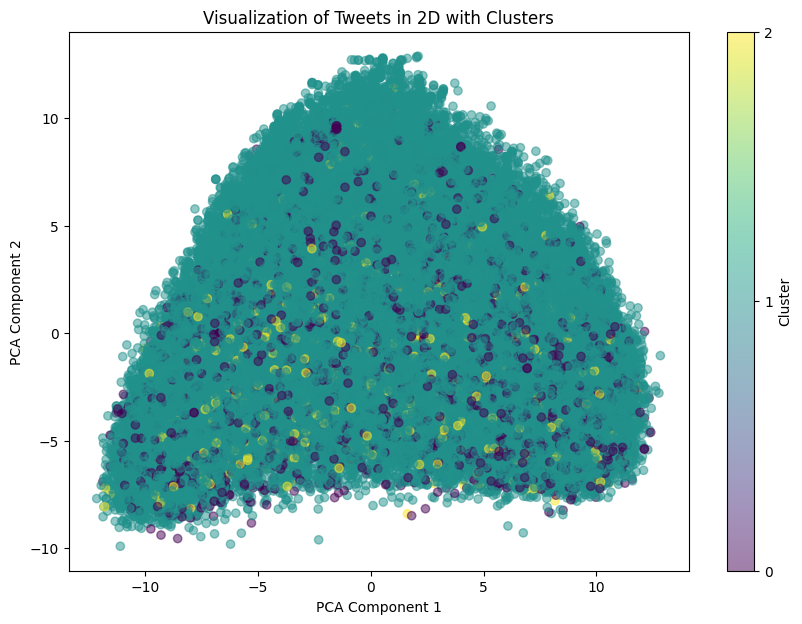

In [132]:
# Преобразование эмбеддингов в двумерное пространство для визуализации
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Визуализация кластеров с текстовыми метками
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=df['cluster'].astype('category').cat.codes, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=[0, 1, 2], label='Cluster')
plt.title('Visualization of Tweets in 2D with Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [133]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
# Предсказанные сентименты по кластерам
y_pred = df['cluster']
y_true = df['sentiment_label']
# Оценка точности
print("Accuracy:", accuracy_score(y_true, y_pred))


Accuracy: 0.509422159668465


In [134]:
# Печать матрицы ошибок и 
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Confusion Matrix:
[[ 1146 10560   228]
 [ 3551 37434  1082]
 [ 2046 20177   510]]


In [135]:
# отчета по классификации
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.17      0.10      0.12     11934
     Neutral       0.55      0.89      0.68     42067
    Positive       0.28      0.02      0.04     22733

    accuracy                           0.51     76734
   macro avg       0.33      0.34      0.28     76734
weighted avg       0.41      0.51      0.40     76734



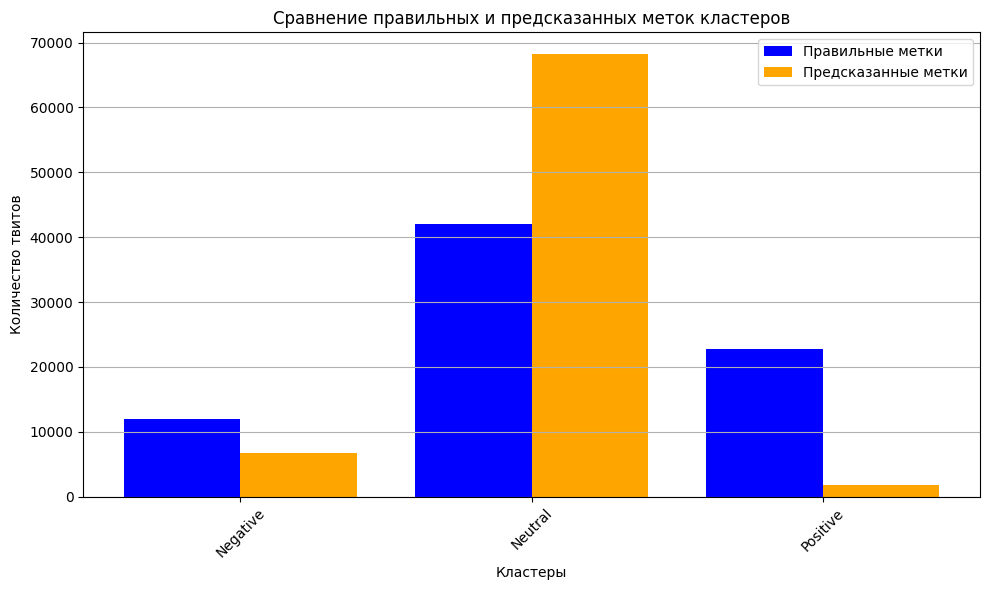

In [136]:
# Подсчет количества твитов по меткам
true_counts = df['sentiment_label'].value_counts().sort_index()
pred_counts = df['cluster'].value_counts().sort_index()

# Подготовка данных для графика
clusters = sorted(set(true_counts.index).union(set(pred_counts.index)))
true_values = [true_counts.get(cluster, 0) for cluster in clusters]
pred_values = [pred_counts.get(cluster, 0) for cluster in clusters]

# Построение столбчатой диаграммы
x = range(len(clusters))
plt.figure(figsize=(10, 6))
plt.bar(x, true_values, width=0.4, label='Правильные метки', color='blue', align='center')
plt.bar([i + 0.4 for i in x], pred_values, width=0.4, label='Предсказанные метки', color='orange', align='center')

# Настройки графика
plt.xlabel('Кластеры')
plt.ylabel('Количество твитов')
plt.title('Сравнение правильных и предсказанных меток кластеров')
plt.xticks([i + 0.2 for i in x], clusters, rotation=45)
plt.legend()
plt.grid(axis='y')

# Отображение графика
plt.tight_layout()
plt.show()